In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle
from IPython.display import HTML
from scipy.interpolate import interp1d

Below is the implementation code of ZO-EG

In [2]:
def sample_gaussian_distribution(d):
    v = np.random.normal(0,1, size=d) 
    return v
def grad(func,x,y,u1,u2,mu=0.05,xy = 'x'):
    perturbation1 = mu*u1
    perturbation2 = mu*u2
    g = (func(x+perturbation1,y+perturbation2)-func(x,y))/mu
    if xy == 'x':
        return g*u1
    if xy == 'y':
        return g*u2

def step_x(func,xs,ys,x,y,u1,u2,h,mu=0.05):
    grd = grad(func,x,y,u1,u2,mu,xy='x')
    xx = xs - h*grd
    return xx
def step_y(func,xs,ys,x,y,u1,u2,h,mu=0.05):
    grd = grad(func,x,y,u1,u2,mu,xy='y')
    yy = ys + h*grd
    return yy

def ZOEG(func,x0,y0,N,h_1 = 0.001,h_2=0.001,mu=0.05,flag2 = 'not_c',projx = None, projy = None):
    dim1 = len(x0)
    dim2 = len(y0)
    x=np.zeros((dim1,N+1))
    x[:,0]=x0
    y=np.zeros((dim2,N+1))
    y[:,0]=y0
    if flag2 == 'not_c':
        for k in range(N):
            u1 = sample_gaussian_distribution(len(x0))
            u2 = sample_gaussian_distribution(len(y0))
            xh = step_x(func,x[:,k],y[:,k],x[:,k],y[:,k],u1,u2,h_1,mu)
            yh = step_y(func,x[:,k],y[:,k],x[:,k],y[:,k],u1,u2,h_1,mu)
            u1 = sample_gaussian_distribution(len(x0))
            u2 = sample_gaussian_distribution(len(y0))
            x[:,k+1] = step_x(func,x[:,k],y[:,k],xh,yh,u1,u2,h_2,mu)
            y[:,k+1] = step_y(func,x[:,k],y[:,k],xh,yh,u1,u2,h_2,mu)
    if flag2 == 'c':
        for k in range(N):
            u1 = sample_gaussian_distribution(len(x))
            u2 = sample_gaussian_distribution(len(y))
            xh = projx(step_x(func,x[:,k],y[:,k],x[:,k],y[:,k],u1,u2,h_1,mu))
            yh = projy(step_y(func,x[:,k],y[:,k],x[:,k],y[:,k],u1,u2,h_1,mu))
            u1 = sample_gaussian_distribution(len(x))
            u2 = sample_gaussian_distribution(len(y))
            x[:,k+1] = projx(step_x(func,x[:,k],y[:,k],xh,yh,u1,u2,h_2,mu))
            y[:,k+1] = projy(step_y(func,x[:,k],y[:,k],xh,yh,u1,u2,h_2,mu))
    return x,y

Below is just a simple test to see if the algorithm is implemented correctly

In [3]:
def f(x,y):
    return x*y
x0 = np.array([1])
y0 = np.array([1])
num = 100000
MC =2
xf=np.zeros((1,num+1,))
yf=np.zeros((1,num+1,))
for i in range(MC):
    x,y = ZOEG(f,x0,y0,num,h_1 = 2e-1,h_2 = 1e-1,mu=1e-8)
    xf += x
    yf += y
xf = xf/MC
yf = yf/MC

print("final X and Y with g",xf[:,-1],yf[:,-1])

final X and Y with g [2.09297794e-08] [-2.33055785e-08]


Below is the code for the models of cars 1 and 2

In [4]:
class BicycleModel:
    def __init__(self, L, max_steer, max_speed, max_accel,T):
        self.L = L
        self.max_steer = max_steer
        self.max_speed = max_speed
        self.max_accel = max_accel
        self.T =T
    
    def dynamics(self, state, t,u):
        x, y, theta, v = state
        time = np.linspace(0, 20, self.T)
        interp_var1 = interp1d(time, u, kind='linear',fill_value="extrapolate")
        a = interp_var1(t)
        # a = np.clip(a, -self.max_accel, self.max_accel)
        delta = 0

        dx = v * np.cos(theta)
        dy = v * np.sin(theta)
        dtheta = v * np.tan(delta) / self.L
        if v >= self.max_speed and a > 0:
            dv = 0
        else:
            dv = a
        
        if v + dv > self.max_speed:
            dv = self.max_speed - v


        return [dx, dy, dtheta, dv]

class BicycleModel2:
    def __init__(self, L, max_steer, max_speed, max_accel,T):
        self.L = L
        self.max_steer = max_steer
        self.max_speed = max_speed
        self.max_accel = max_accel
        self.T = T
    
    def dynamics(self, state, t,u):
        x, y, theta, v = state
        time = np.linspace(0, 20, self.T) 
        interp_var1 = interp1d(time, u[0], kind='linear',fill_value="extrapolate")
        interp_var2 = interp1d(time, u[1], kind='linear',fill_value="extrapolate")
        a = interp_var1(t)
        delta = interp_var2(t)
        # a = np.clip(a, -self.max_accel, self.max_accel)
        # delta = np.clip(delta, -self.max_steer, self.max_steer)

        dx = v * np.cos(theta)
        dy = v * np.sin(theta)
        dtheta = v * np.tan(delta) / self.L
        if v >= self.max_speed and a > 0:
            dv = 0
        else:
            dv = a
        
        if v + dv > self.max_speed:
            dv = self.max_speed - v


        return [dx, dy, dtheta, dv]

def simulate_car(car, initial_state, t, u):
    def system(state, t):
        return car.dynamics(state, t, u)
    
    solution = odeint(system, initial_state, t)
    return solution






# L = 4
# W = 2
# max_steer = np.pi/20
# max_speed = 5
# max_accel = 1
# T=100
# car1 = BicycleModel(L, max_steer, max_speed, max_accel,T)
# car2 = BicycleModel2(L, max_steer, max_speed, max_accel,T)


# initial_states = [
#     [0, 5, 0, 2],  
#     [5, 0, 0, 3] 
# ]

# t= np.linspace(0, 20, 100) 
# u1_0 = np.ones_like(t)
# u2_0 = np.vstack([np.ones_like(t),np.zeros_like(t)])
# print(u1_0.shape,u2_0.shape,t.shape)

# state_car1 = simulate_car(car1, initial_states[0],t, u1_0)
# state_car2 = simulate_car(car2, initial_states[1],t, u2_0)


# # Combine the states for animation (concatenate along axis 1)
# states_combined = np.hstack([state_car1, state_car2])

# # Animation (similar as before)
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.set_xlim(-10, 100)
# ax.set_ylim(-10, 10)
# ax.set_aspect('equal')
# ax.set_xlabel('X position (m)')
# ax.set_ylabel('Y position (m)')
# ax.set_title('Optimized Lane Merge')
# plt.grid('on')

# car_colors = ['r', 'b']
# car_patches = [Rectangle((0, 0), L, W, fc=color, ec='k') for color in car_colors]
# for patch in car_patches:
#     ax.add_patch(patch)

# car_trails = [ax.plot([], [], '--', color=color)[0] for color in car_colors]

# def init():
#     for patch in car_patches:
#         patch.set_xy((-2, -1))
#     for trail in car_trails:
#         trail.set_data([], [])
#     return car_patches + car_trails

# def animate(i):
#     for j, patch in enumerate(car_patches):
#         x, y, theta, _ = states_combined[i, j*4:(j+1)*4]
#         patch.set_xy((x - 2, y - 1))
#         patch.set_angle(np.degrees(theta))
        
#         trail = car_trails[j]
#         trail_data = trail.get_data()
#         trail_x = np.append(trail_data[0], x)
#         trail_y = np.append(trail_data[1], y)
#         trail.set_data(trail_x, trail_y)
    
#     return car_patches + car_trails

# anim = FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=100, blit=True)

# plt.close(fig)
# HTML(anim.to_jshtml())




The loss functions are implemented below

In [6]:
def loss_car1(state1, state2):
    """Car 1: Maximize velocity and avoid collision."""
    x1, y1, theta1, v1 = state1[:,0],state1[:,1],state1[:,2],state1[:,3]
    x2, y2, theta2, v2 = state2[:,0],state2[:,1],state2[:,2],state2[:,3]
    
    # Penalty for proximity to car 2 (collision avoidance)
    distance_penalty = np.exp(-((x1 - x2)**2 + (y1 - y2)**2))

    loss = 1/2*v1**2 - 2*distance_penalty
    return np.sum(loss)

def loss_car2(state1, state2):
    x1, y1, theta1, v1 = state1[:,0],state1[:,1],state1[:,2],state1[:,3]
    x2, y2, theta2, v2 = state2[:,0],state2[:,1],state2[:,2],state2[:,3]
    
    distance_penalty = np.exp(-((x1 - x2)**2 + (y1 - y2)**2))
    merge_penalty = (y2 - 5)**2  # Target lane is y = 5
    
    loss = distance_penalty + 10*merge_penalty
    return np.sum(loss)

L = 4
W = 2
max_steer = np.pi/30
max_speed = 10
max_accel = 1
T =50
car1 = BicycleModel(L, max_steer, max_speed, max_accel,T)
car2 = BicycleModel2(L, max_steer, max_speed, max_accel,T)


initial_states = [
    [0, 5, 0, 2],  
    [5, 0, 0, 3] 
]

t= np.linspace(0, 20, T) 
u1_0 = np.ones_like(t)
u2_0 = np.vstack([np.ones_like(t),np.zeros_like(t)])
u2_0=u2_0.flatten()

def total_loss(u2,u1):
        # print(u2)
        B = np.zeros((2, len(u2)//2))
        B[0, :] = u2[0:len(u2)//2]  
        B[1, :] = u2[len(u2)//2::]
        u2 = B
        # print(u2)
        state1 = simulate_car(car1, initial_states[0],t,u1)
        state2 = simulate_car(car2, initial_states[1],t,u2)

        loss1 = loss_car1(state1, state2)
        loss2 = loss_car2(state1, state2)
        
        return loss1 + loss2

total_loss(u2_0,u1_0)

14388.941996586584

Below is the implmenetation of projection operators

In [6]:
def projx(x):
    mid = len(x)//2
    x[:mid] = np.clip(x[:mid], 0, max_accel)
    x[mid:] = np.clip(x[mid:], -max_steer, max_steer)

    return x

def projy(y):

    y = np.clip(y, 0, max_accel)

    return y

The following code solves the min-max problem. The initial condition is loaded from the final result of a previous run. Since the algorithm is computationally intensive, we have split it into two stages of 2000 iterations each, using the final output of the first stage as the initial guess for the second stage.

In [ ]:
MC =1
num =2000
L = 4
W = 2
max_steer = np.pi/30
max_speed = 10
max_accel = 1
T =50
car1 = BicycleModel(L, max_steer, max_speed, max_accel,T)
car2 = BicycleModel2(L, max_steer, max_speed, max_accel,T)

initial_states = [
    [0, 5, 0, 2],  
    [5, 0, 0, 3] 
]

t= np.linspace(0, 20, T) 
# u1_0 = np.ones_like(t)*1
# u2_0 = np.vstack([np.ones_like(t)*1,np.zeros_like(t)])
# u2_0=u2_0.flatten()

u1_0 = np.load("u1f.npy")[:,-1]
u2_0 = np.load("u2f.npy")[:,-1]


u2f=np.zeros((u2_0.shape[0],num+1,))
u1f=np.zeros((u1_0.shape[0],num+1,))
for i in range(MC):
    u2,u1 = ZOEG(total_loss,u2_0,u1_0,num,h_1 = 1e-9,h_2 = 1e-9,mu=1e-6,flag2='c',projx=projx,projy=projy)
    u2f += u2
    u1f += u1
u2f = u2f/MC
u1f = u1f/MC


u2p = u2f[:,-1]
u1p = u1f[:,-1]

B = np.zeros((2, len(u2p)//2))
B[0, :] = u2p[0:len(u2p)//2]  
B[1, :] = u2p[len(u2p)//2::]
u2p = B

In [ ]:
state_car1 = simulate_car(car1, initial_states[0],t, u1p)
state_car2 = simulate_car(car2, initial_states[1],t, u2p)


# Combine the states for animation (concatenate along axis 1)
states_combined = np.hstack([state_car1, state_car2])

# Animation (similar as before)
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(-10, 200)
ax.set_ylim(-20, 20)
ax.set_aspect('equal')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_title('Optimized Lane Merge')
plt.grid('on')

car_colors = ['r', 'b']
car_patches = [Rectangle((0, 0), L, W, fc=color, ec='k') for color in car_colors]
for patch in car_patches:
    ax.add_patch(patch)

car_trails = [ax.plot([], [], '--', color=color)[0] for color in car_colors]

def init():
    for patch in car_patches:
        patch.set_xy((-2, -1))
    for trail in car_trails:
        trail.set_data([], [])
    return car_patches + car_trails

def animate(i):
    for j, patch in enumerate(car_patches):
        x, y, theta, _ = states_combined[i, j*4:(j+1)*4]
        patch.set_xy((x - 2, y - 1))
        patch.set_angle(np.degrees(theta))
        
        trail = car_trails[j]
        trail_data = trail.get_data()
        trail_x = np.append(trail_data[0], x)
        trail_y = np.append(trail_data[1], y)
        trail.set_data(trail_x, trail_y)
    
    return car_patches + car_trails

anim = FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=100, blit=True)

plt.close(fig)
HTML(anim.to_jshtml())

In [ ]:
first_frame = states_combined[0]
last_frame = states_combined[-1]

# Create the figure and subplots for the first and last frames
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

font = {'family': 'serif', 'weight': 'normal', 'size': 20}
font1 = {'family': 'serif', 'size': 12}
# Common settings for both subplots
for ax in [ax1, ax2]:
    ax.set_xlim(-10, 200)
    ax.set_ylim(-20, 20)
    ax.set_aspect('equal')
    ax.set_xlabel('X position (m)',fontdict=font)
    ax.set_ylabel('Y position (m)',fontdict=font)
    ax.tick_params(axis='x', labelsize=20, labelcolor='black')
    ax.tick_params(axis='y', labelsize=20, labelcolor='black')
    ax.grid(True)

# Titles for subplots
ax1.set_title('First Frame',fontdict=font)
ax2.set_title('Last Frame',fontdict=font)

# Function to draw car positions and (conditionally) trails in a subplot
def draw_frame(ax, frame, show_trail,label):
    for j, patch_color in enumerate(car_colors):
        x, y, theta, _ = frame[j*4:(j+1)*4]  # Get the car state (x, y, theta, v)
        
        # Plot car's position
        car_patch = Rectangle((x - 2, y - 1), L, W, fc=patch_color, ec='k',label = label)
        ax.add_patch(car_patch)
        car_patch.set_angle(np.degrees(theta))
        
        # Optionally plot car's trail up to the current frame
        if show_trail:
            trail_x = states_combined[:len(t), j*4]  # Get all x positions for car j
            trail_y = states_combined[:len(t), j*4 + 1]  # Get all y positions for car j
            ax.plot(trail_x, trail_y, '--', color=patch_color, label=f"Car {j+1} Path",linewidth=2)

# Draw the first frame without paths in the first subplot
draw_frame(ax1, first_frame, show_trail=False,label="Initial car position")

# Draw the last frame with paths in the second subplot
draw_frame(ax2, last_frame, show_trail=True,label="Final car position")

# Add legend to the second subplot (for the car paths)
ax1.legend(prop=font1,loc='best')
ax2.legend(prop=font1,loc='best')

# Display the plot
plt.tight_layout()
# plt.savefig('Pics/Lane_merge.pdf', format='pdf',bbox_inches='tight')



In [ ]:
lossf = []
for i in range(num):
    lossf.append(total_loss(u2f[:,i],u1f[:,i]))
lossf = np.array(lossf)

Below is the plot of loss function and the animated output.

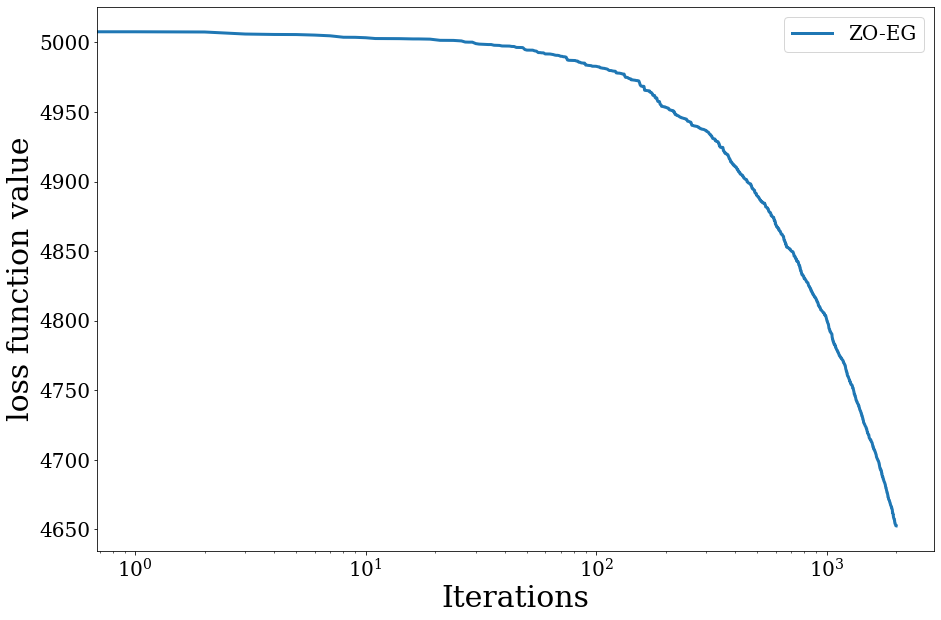

In [79]:
font = {'family': 'serif', 'weight': 'normal', 'size': 30}
font1 = {'family': 'serif', 'size': 20}
plt.figure(figsize=(15,10))
plt.plot(np.array(range(num)) ,lossf,label='ZO-EG',linewidth=3)
plt.xticks(fontname='serif', fontsize=20, color='black')
plt.yticks(fontname='serif', fontsize=20, color='black')
plt.xscale('log')
plt.xlabel('Iterations',fontdict=font)
plt.ylabel('loss function value',fontdict=font)
plt.legend(loc='best', prop=font1)
# plt.savefig('Pics/Lane_merge2.pdf', format='pdf',bbox_inches='tight')

In [ ]:
# u1f = np.load("u1f2.npy")
# u2f = np.load("u2f2.npy")


In [81]:
# np.save("u1f.npy",u1f)
# np.save("u2f.npy",u2f)

In [ ]:
L = 4
W = 2
max_steer = np.pi/30
max_speed = 10
max_accel = 1
T =50
car1 = BicycleModel(L, max_steer, max_speed, max_accel,T)
car2 = BicycleModel2(L, max_steer, max_speed, max_accel,T)


initial_states = [
    [0, 5, 0, 2],  
    [5, 0, 0, 3] 
]

t= np.linspace(0, 20, 50) 
u1_0 = np.load("u1f.npy")[:,-1]
u2_0 = np.load("u2f.npy")[:,-1]
# u1_0 = np.load("u1f2.npy")[:,-1]
# u2_0 = np.load("u2f2.npy")[:,-1]
B = np.zeros((2, len(u2_0)//2))
B[0, :] = u2_0[0:len(u2_0)//2]  
B[1, :] = u2_0[len(u2_0)//2::]
u2_0 = B
print(u1_0.shape, u2_0.shape,t.shape)

state_car1 = simulate_car(car1, initial_states[0],t, u1_0)
state_car2 = simulate_car(car2, initial_states[1],t, u2_0)


# Combine the states for animation (concatenate along axis 1)
states_combined = np.hstack([state_car1, state_car2])

# Animation (similar as before)
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(-10, 200)
ax.set_ylim(-20, 20)
ax.set_aspect('equal')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_title('Optimized Lane Merge')
plt.grid('on')

car_colors = ['r', 'b']
car_patches = [Rectangle((0, 0), L, W, fc=color, ec='k') for color in car_colors]
for patch in car_patches:
    ax.add_patch(patch)

car_trails = [ax.plot([], [], '--', color=color)[0] for color in car_colors]

def init():
    for patch in car_patches:
        patch.set_xy((-2, -1))
    for trail in car_trails:
        trail.set_data([], [])
    return car_patches + car_trails

def animate(i):
    for j, patch in enumerate(car_patches):
        x, y, theta, _ = states_combined[i, j*4:(j+1)*4]
        patch.set_xy((x - 2, y - 1))
        patch.set_angle(np.degrees(theta))
        
        trail = car_trails[j]
        trail_data = trail.get_data()
        trail_x = np.append(trail_data[0], x)
        trail_y = np.append(trail_data[1], y)
        trail.set_data(trail_x, trail_y)
    
    return car_patches + car_trails

anim = FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=100, blit=True)

plt.close(fig)
HTML(anim.to_jshtml())

(50,) (2, 50) (50,)


In [ ]:
# u1_0 = np.load("u1f.npy")
# u2_0 = np.load("u2f.npy")
# num = u1_0.shape[1]
# lossf = []
# for i in range(0,num,10):
#     lossf.append(total_loss(u2_0[:,i],u1_0[:,i]))
# lossf = np.array(lossf)

Below is the plot of the loss function over the combined 4000 iterations (two stages of 2000 iterations each), along with the corresponding output plot.

In [7]:
u1_0 = np.load("u1f.npy")
u2_0 = np.load("u2f.npy")
u1_00 = np.load("u1f2.npy")
u2_00 = np.load("u2f2.npy")
u1_000 = np.hstack((u1_0, u1_00))
u2_000 = np.hstack((u2_0, u2_00))
num = u1_000.shape[1]
lossf = []
for i in range(0,num,10):
    lossf.append(total_loss(u2_000[:,i],u1_000[:,i]))
lossf = np.array(lossf)

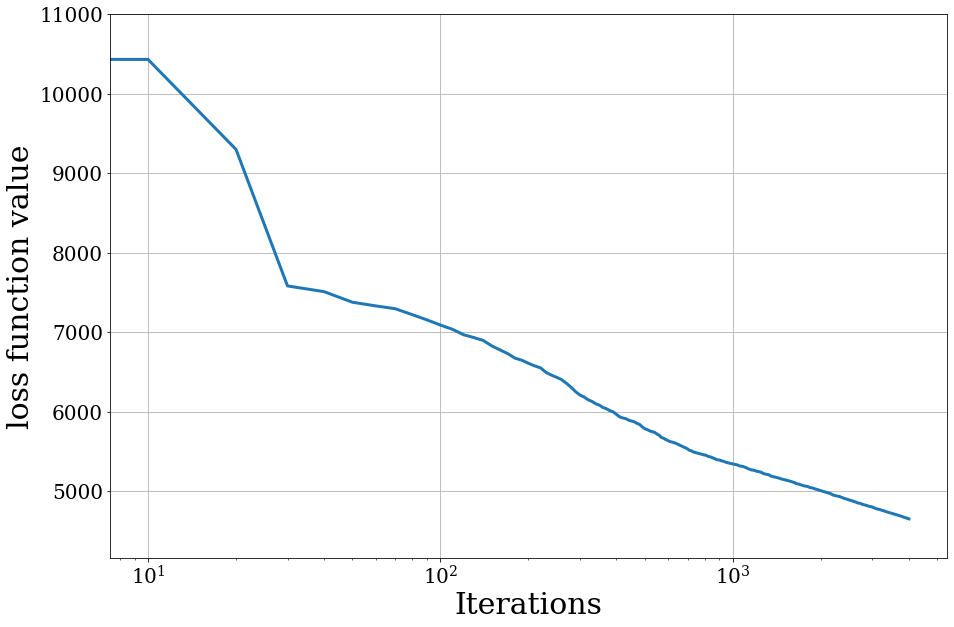

In [ ]:
font = {'family': 'serif', 'weight': 'normal', 'size': 30}
font1 = {'family': 'serif', 'size': 20}
plt.figure(figsize=(15,10))
plt.plot(np.array(range(0,num,10)) ,lossf,label='ZO-EG',linewidth=3)
plt.xticks(fontname='serif', fontsize=20, color='black')
plt.yticks(fontname='serif', fontsize=20, color='black')
plt.xscale('log')
plt.grid('on')
y_min, _ = plt.ylim()
plt.ylim(y_min,11000)
plt.xlabel('Iterations',fontdict=font)
plt.ylabel('loss function value',fontdict=font)
# plt.savefig('Pics/Lane_merge2.pdf', format='pdf',bbox_inches='tight')


In [21]:
u1_0 = np.load("u1f.npy")
u2_0 = np.load("u2f.npy")
u1_00 = np.load("u1f2.npy")
u2_00 = np.load("u2f2.npy")
u1 = np.hstack((u1_0, u1_00))[:,-1]
u2 = np.hstack((u2_0, u2_00))[:,-1]
B = np.zeros((2, len(u2)//2))
B[0, :] = u2[0:len(u2)//2]  
B[1, :] = u2[len(u2)//2::]
u2 = B

state_car1 = simulate_car(car1, initial_states[0],t, u1)
state_car2 = simulate_car(car2, initial_states[1],t, u2)


# Combine the states for animation (concatenate along axis 1)
states_combined = np.hstack([state_car1, state_car2])

# Animation (similar as before)
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(-10, 200)
ax.set_ylim(-20, 20)
ax.set_aspect('equal')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_title('Optimized Lane Merge')
plt.grid('on')

car_colors = ['r', 'b']
car_patches = [Rectangle((0, 0), L, W, fc=color, ec='k') for color in car_colors]
for patch in car_patches:
    ax.add_patch(patch)

car_trails = [ax.plot([], [], '--', color=color)[0] for color in car_colors]

def init():
    for patch in car_patches:
        patch.set_xy((-2, -1))
    for trail in car_trails:
        trail.set_data([], [])
    return car_patches + car_trails

def animate(i):
    for j, patch in enumerate(car_patches):
        x, y, theta, _ = states_combined[i, j*4:(j+1)*4]
        patch.set_xy((x - 2, y - 1))
        patch.set_angle(np.degrees(theta))
        
        trail = car_trails[j]
        trail_data = trail.get_data()
        trail_x = np.append(trail_data[0], x)
        trail_y = np.append(trail_data[1], y)
        trail.set_data(trail_x, trail_y)
    
    return car_patches + car_trails

anim = FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=100, blit=True)

plt.close(fig)
HTML(anim.to_jshtml())

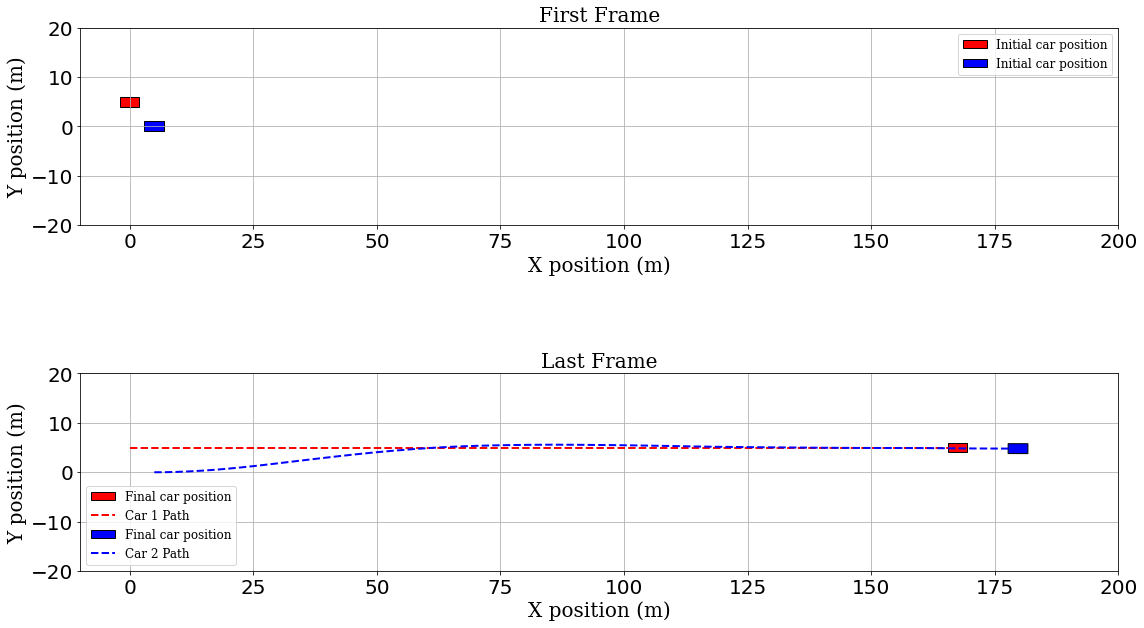

In [23]:
first_frame = states_combined[0]
last_frame = states_combined[-1]

# Create the figure and subplots for the first and last frames
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

font = {'family': 'serif', 'weight': 'normal', 'size': 20}
font1 = {'family': 'serif', 'size': 12}
# Common settings for both subplots
for ax in [ax1, ax2]:
    ax.set_xlim(-10, 200)
    ax.set_ylim(-20, 20)
    ax.set_aspect('equal')
    ax.set_xlabel('X position (m)',fontdict=font)
    ax.set_ylabel('Y position (m)',fontdict=font)
    ax.tick_params(axis='x', labelsize=20, labelcolor='black')
    ax.tick_params(axis='y', labelsize=20, labelcolor='black')
    ax.grid(True)

# Titles for subplots
ax1.set_title('First Frame',fontdict=font)
ax2.set_title('Last Frame',fontdict=font)

# Function to draw car positions and (conditionally) trails in a subplot
def draw_frame(ax, frame, show_trail,label):
    for j, patch_color in enumerate(car_colors):
        x, y, theta, _ = frame[j*4:(j+1)*4]  # Get the car state (x, y, theta, v)
        
        # Plot car's position
        car_patch = Rectangle((x - 2, y - 1), L, W, fc=patch_color, ec='k',label = label)
        ax.add_patch(car_patch)
        car_patch.set_angle(np.degrees(theta))
        
        # Optionally plot car's trail up to the current frame
        if show_trail:
            trail_x = states_combined[:len(t), j*4]  # Get all x positions for car j
            trail_y = states_combined[:len(t), j*4 + 1]  # Get all y positions for car j
            ax.plot(trail_x, trail_y, '--', color=patch_color, label=f"Car {j+1} Path",linewidth=2)

# Draw the first frame without paths in the first subplot
draw_frame(ax1, first_frame, show_trail=False,label="Initial car position")

# Draw the last frame with paths in the second subplot
draw_frame(ax2, last_frame, show_trail=True,label="Final car position")

# Add legend to the second subplot (for the car paths)
ax1.legend(prop=font1,loc='best')
ax2.legend(prop=font1,loc='best')

# Display the plot
plt.tight_layout()
# plt.savefig('Pics/Lane_merge.pdf', format='pdf',bbox_inches='tight')

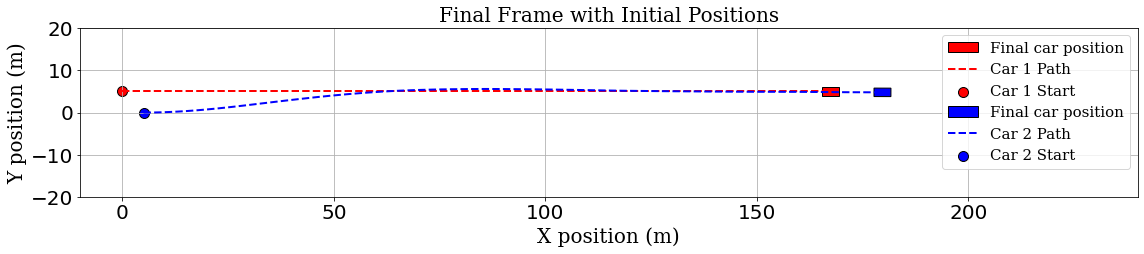

In [ ]:
# Create the figure with a single subplot
fig, ax = plt.subplots(figsize=(16, 10))

font = {'family': 'serif', 'weight': 'normal', 'size': 20}
font1 = {'family': 'serif', 'size': 15}

# Set axis limits and labels
ax.set_xlim(-10, 240)
ax.set_ylim(-20, 20)
ax.set_aspect('equal')
ax.set_xlabel('X position (m)', fontdict=font)
ax.set_ylabel('Y position (m)', fontdict=font)
ax.tick_params(axis='x', labelsize=20, labelcolor='black')
ax.tick_params(axis='y', labelsize=20, labelcolor='black')
ax.grid(True)
ax.set_title('Final Frame with Initial Positions', fontdict=font)

# Function to draw car positions and trails
def draw_frame(ax, frame, initial_frame, label):
    for j, patch_color in enumerate(car_colors):
        x, y, theta, _ = frame[j*4:(j+1)*4]  # Get the final car state (x, y, theta, v)
        
        # Draw final car position
        car_patch = Rectangle((x - 2, y - 1), L, W, fc=patch_color, ec='k', label=label)
        ax.add_patch(car_patch)
        car_patch.set_angle(np.degrees(theta))
        
        # Draw car's trajectory
        trail_x = states_combined[:len(t), j*4]  
        trail_y = states_combined[:len(t), j*4 + 1]
        ax.plot(trail_x, trail_y, '--', color=patch_color, label=f"Car {j+1} Path", linewidth=2)
        
        # Annotate initial position
        x_init, y_init, _, _ = initial_frame[j*4:(j+1)*4]
        ax.scatter(x_init, y_init, color=patch_color, edgecolor='black', s=100, marker='o', label=f"Car {j+1} Start")
        # ax.annotate(f"Start {j+1}", (x_init, y_init), textcoords="offset points", xytext=(5,5), fontsize=15, color=patch_color)

# Draw the last frame with paths and initial positions
draw_frame(ax, last_frame, first_frame, label="Final car position")

# Add legend
ax.legend(prop=font1, loc='best')

# Display the plot
plt.tight_layout()
# plt.savefig('Pics/Lane_merge.pdf', format='pdf', bbox_inches='tight')


Below is the result of another test with different hyperparameters

In [ ]:
MC =1
num = 5000
L = 4
W = 2
max_steer = np.pi/30
max_speed = 10
max_accel = 1
T =20
car1 = BicycleModel(L, max_steer, max_speed, max_accel,T)
car2 = BicycleModel2(L, max_steer, max_speed, max_accel,T)

initial_states = [
    [0, 5, 0, 2],  
    [5, 0, 0, 3] 
]

t= np.linspace(0, 20, T) 

# u1_0 = np.ones_like(t)*1
# u2_0 = np.vstack([np.ones_like(t)*1,np.zeros_like(t)])
# u2_0=u2_0.flatten()

u1_0 = np.load("u1fT20.npy")[:,-1]
u2_0 = np.load("u2fT20.npy")[:,-1]

u2f=np.zeros((u2_0.shape[0],num+1,))
u1f=np.zeros((u1_0.shape[0],num+1,))
for i in range(MC):
    u2,u1 = ZOEG(total_loss,u2_0,u1_0,num,h_1 = 1e-9,h_2 = 1e-9,mu=1e-6,flag2='c',projx=projx,projy=projy)
    u2f += u2
    u1f += u1
u2f = u2f/MC
u1f = u1f/MC


u2p = u2f[:,-1]
u1p = u1f[:,-1]

B = np.zeros((2, len(u2p)//2))
B[0, :] = u2p[0:len(u2p)//2]  
B[1, :] = u2p[len(u2p)//2::]
u2p = B

In [ ]:
# np.save("u1fT20.npy",u1f)
# np.save("u2fT20.npy",u2f)

# np.save("u1fT202.npy",u1f)
# np.save("u2fT202.npy",u2f)

# u1f = np.load("u1fT20.npy")
# u2f = np.load("u2fT20.npy")

# u1f = np.load("u1fT202.npy")
# u2f = np.load("u2fT202.npy")

# u2p = u2f[:,-1]
# u1p = u1f[:,-1]

# B = np.zeros((2, len(u2p)//2))
# B[0, :] = u2p[0:len(u2p)//2]  
# B[1, :] = u2p[len(u2p)//2::]
# u2p = B

In [82]:
state_car1 = simulate_car(car1, initial_states[0],t, u1p)
state_car2 = simulate_car(car2, initial_states[1],t, u2p)


# Combine the states for animation (concatenate along axis 1)
states_combined = np.hstack([state_car1, state_car2])

# Animation (similar as before)
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(-10, 200)
ax.set_ylim(-20, 20)
ax.set_aspect('equal')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_title('Optimized Lane Merge')
plt.grid('on')

car_colors = ['r', 'b']
car_patches = [Rectangle((0, 0), L, W, fc=color, ec='k') for color in car_colors]
for patch in car_patches:
    ax.add_patch(patch)

car_trails = [ax.plot([], [], '--', color=color)[0] for color in car_colors]

def init():
    for patch in car_patches:
        patch.set_xy((-2, -1))
    for trail in car_trails:
        trail.set_data([], [])
    return car_patches + car_trails

def animate(i):
    for j, patch in enumerate(car_patches):
        x, y, theta, _ = states_combined[i, j*4:(j+1)*4]
        patch.set_xy((x - 2, y - 1))
        patch.set_angle(np.degrees(theta))
        
        trail = car_trails[j]
        trail_data = trail.get_data()
        trail_x = np.append(trail_data[0], x)
        trail_y = np.append(trail_data[1], y)
        trail.set_data(trail_x, trail_y)
    
    return car_patches + car_trails

anim = FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=150, blit=True)

plt.close(fig)
HTML(anim.to_jshtml())

1999.653197069848 1813.2239153153523


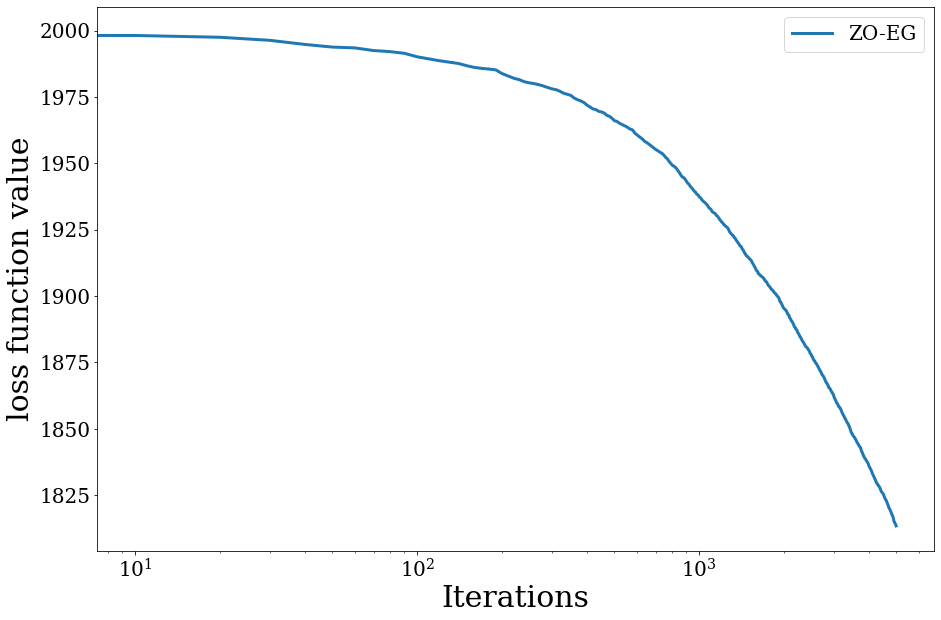

In [83]:
print(total_loss(u2f[:,0],u1f[:,0]),total_loss(u2f[:,-1],u1f[:,-1]))
lossf = []
for i in range(0,num,10):
    lossf.append(total_loss(u2f[:,i],u1f[:,i]))
lossf = np.array(lossf)
font = {'family': 'serif', 'weight': 'normal', 'size': 30}
font1 = {'family': 'serif', 'size': 20}
plt.figure(figsize=(15,10))
plt.plot(np.array(range(0,num,10)) ,lossf,label='ZO-EG',linewidth=3)
plt.xticks(fontname='serif', fontsize=20, color='black')
plt.yticks(fontname='serif', fontsize=20, color='black')
plt.xscale('log')
plt.xlabel('Iterations',fontdict=font)
plt.ylabel('loss function value',fontdict=font)
plt.legend(loc='best', prop=font1)

Below is the implementation of the RK4 method and gradient calculation using JAX, which enables evaluation of the proximal Minty variational inequality.

In [39]:
import jax.numpy as jnp
from jax import grad

def reshape_u2(u2_flat):
    """Reshape flat control input into 2xT matrix"""
    half_len = len(u2_flat) // 2
    return jnp.array([u2_flat[:half_len], u2_flat[half_len:]])

def linear_interp(t, t_points, u_points):
    """Custom linear interpolation function compatible with JAX"""
    slopes = (u_points[1:] - u_points[:-1]) / (t_points[1:] - t_points[:-1])
    idx = jnp.sum(t > t_points) - 1
    idx = jnp.clip(idx, 0, len(t_points) - 2)
    dt = t - t_points[idx]
    return u_points[idx] + slopes[idx] * dt

def euler_integrate(dynamics_fun, initial_state, t, dt):
    n_steps = len(t)
    state_dim = len(initial_state)
    states = jnp.zeros((n_steps, state_dim))
    states = states.at[0].set(initial_state)  # Use JAX's set method

    for i in range(n_steps - 1):
        derivative = dynamics_fun(states[i], t[i])
        states = states.at[i + 1].set(states[i] + derivative * dt)  # Use JAX's set method
    
    return states

def rk4_integrate(dynamics_fun, initial_state, t, dt):
    n_steps = len(t)
    state_dim = len(initial_state)
    states = jnp.zeros((n_steps, state_dim))
    states = states.at[0].set(initial_state)

    for i in range(n_steps - 1):
        k1 = dynamics_fun(states[i], t[i])
        k2 = dynamics_fun(states[i] + 0.5 * dt * k1, t[i] + 0.5 * dt)
        k3 = dynamics_fun(states[i] + 0.5 * dt * k2, t[i] + 0.5 * dt)
        k4 = dynamics_fun(states[i] + dt * k3, t[i] + dt)
        states = states.at[i + 1].set(states[i] + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4))

    return states

class BicycleModel:
    def __init__(self, L, max_steer, max_speed, max_accel, T):
        self.L = L
        self.max_steer = max_steer
        self.max_speed = max_speed
        self.max_accel = max_accel
        self.T = T
    
    def dynamics(self, state, t, u):
        x, y, theta, v = state
        time = jnp.linspace(0, 20, self.T)
        a = linear_interp(t, time, u)
        a = jnp.clip(a, 0, self.max_accel)
        delta = 0.0

        dx = v * jnp.cos(theta)
        dy = v * jnp.sin(theta)
        dtheta = v * jnp.tan(delta) / self.L
        dv = jnp.where(v >= self.max_speed, 
                     jnp.minimum(0.0, a),
                     jnp.minimum(a, self.max_speed - v))

        return jnp.array([dx, dy, dtheta, dv])

class BicycleModel2:
    def __init__(self, L, max_steer, max_speed, max_accel, T):
        self.L = L
        self.max_steer = max_steer
        self.max_speed = max_speed
        self.max_accel = max_accel
        self.T = T
    
    def dynamics(self, state, t, u_flat):
        x, y, theta, v = state
        time = jnp.linspace(0, 20, self.T)
        u = reshape_u2(u_flat)
        
        a = linear_interp(t, time, u[0])
        delta = linear_interp(t, time, u[1])
        
        a = jnp.clip(a, 0, self.max_accel)
        delta = jnp.clip(delta, -self.max_steer, self.max_steer)

        dx = v * jnp.cos(theta)
        dy = v * jnp.sin(theta)
        dtheta = v * jnp.tan(delta) / self.L
        dv = jnp.where(v >= self.max_speed, 
                     jnp.minimum(0.0, a),
                     jnp.minimum(a, self.max_speed - v))

        return jnp.array([dx, dy, dtheta, dv])

def simulate_car(car, initial_state, t, u):
    dt = t[1] - t[0]
    
    def dynamics_wrapper(state, t):
        return car.dynamics(state, t, u)
    
    return rk4_integrate(dynamics_wrapper, initial_state, t, dt)



def loss_car1(state1, state2):
    """Car 1: Maximize velocity and avoid collision."""
    x1, y1, theta1, v1 = state1[:,0],state1[:,1],state1[:,2],state1[:,3]
    x2, y2, theta2, v2 = state2[:,0],state2[:,1],state2[:,2],state2[:,3]
    
    # Penalty for proximity to car 2 (collision avoidance)
    distance_penalty = jnp.exp(-((x1 - x2)**2 + (y1 - y2)**2))
    # distance_penalty = 1 / (((x1 - x2)**2 + (y1 - y2)**2) + 1e-6)

    loss = 1/2*v1**2 - 2*distance_penalty
    return jnp.sum(loss)

def loss_car2(state1, state2):
    x1, y1, theta1, v1 = state1[:,0],state1[:,1],state1[:,2],state1[:,3]
    x2, y2, theta2, v2 = state2[:,0],state2[:,1],state2[:,2],state2[:,3]
    
    distance_penalty = jnp.exp(-((x1 - x2)**2 + (y1 - y2)**2))
    # distance_penalty = 1 / (((x1 - x2)**2 + (y1 - y2)**2) + 1e-6)
    merge_penalty = (y2 - 5)**2  # Target lane is y = 5
    
    loss = distance_penalty + 10*merge_penalty
    return jnp.sum(loss)


def total_loss(u2_flat, u1):
    state1 = simulate_car(car1, initial_states[0], t, u1)
    state2 = simulate_car(car2, initial_states[1], t, u2_flat)
    
    loss1 = loss_car1(state1, state2)
    loss2 = loss_car2(state1, state2)
    
    return loss1 + loss2

# Initialize parameters
L = 4
W = 2
max_steer = jnp.pi / 30
max_speed = 10
max_accel = 1
T = 20

# Create car instances
car1 = BicycleModel(L, max_steer, max_speed, max_accel, T)
car2 = BicycleModel2(L, max_steer, max_speed, max_accel, T)

# Initial states
initial_states = [
    [0, 5, 0, 2],
    [5, 0, 0, 3]
]

# Time vector
t = jnp.linspace(0, 20, T)

# Initial control inputs
u1_0 = jnp.ones(T)*1
u2_0 = jnp.concatenate([jnp.ones(T)*1, jnp.ones(T)*max_steer*1])  

# Define gradients
grad_u2 = grad(total_loss, 0)
grad_u1 = grad(total_loss, 1)

def check_minty_vi(u2_flat, u1, u2_opt, u1_opt):

    grad_u2_val = grad_u2(u2_flat, u1)
    grad_u1_val = grad_u1(u2_flat, u1)
    # grad_u2_valo = grad_u2(u2_opt, u1_opt)
    # grad_u1_valo = grad_u1(u2_opt, u1_opt)
    # print(jnp.linalg.norm(grad_u2_valo),jnp.linalg.norm(grad_u1_valo))

    delta_u2 = u2_flat - u2_opt
    delta_u1 = u1 - u1_opt

    print(jnp.sum(grad_u2_val * delta_u2),- jnp.sum(grad_u1_val * delta_u1))
    print(grad_u2_val * delta_u2,'\n',grad_u1_val * delta_u1)
    
    mvi = jnp.sum(grad_u2_val * delta_u2) - jnp.sum(grad_u1_val * delta_u1)
    return float(mvi)  

u1_p = jnp.load("u1fT202.npy")[:,-1]
u2_p = jnp.load("u2fT202.npy")[:,-1]
# print(total_loss(u2_p,u1_p))

mvi_value = check_minty_vi(u2_0, u1_0, u2_p, u1_p)
print("Minty Variational Inequality value:", mvi_value)


-582403.6 -0.16348791
[ 2.02462935e+00  1.66602707e+00  2.56138682e-01  5.81715631e+00
  3.88641047e+00  3.74140429e+00  1.33965295e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.82506958e+02 -6.52566284e+02 -4.12020312e+03 -1.15631621e+04
 -2.37615254e+04 -4.19929805e+04 -6.14846875e+04 -7.52545312e+04
 -7.77968672e+04 -7.12487812e+04 -6.25613789e+04 -5.17593125e+04
 -3.87845234e+04 -2.73139863e+04 -1.77600078e+04 -9.89220215e+03
 -4.75973438e+03 -1.65724683e+03 -4.04843719e+02 -3.49927254e+01] 
 [0.00132374 0.03819631 0.03594635 0.00119841 0.06632701 0.01267089
 0.00117838 0.00664681 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Minty Variational Inequality value: -582403.8125


In [40]:
def projx(x):
    mid = len(x) // 2
    x = x.at[:mid].set(jnp.clip(x[:mid], 0, max_accel))
    x = x.at[mid:].set(jnp.clip(x[mid:], -max_steer, max_steer))
    return x

def projy(y):
    y = jnp.clip(y, 0, max_accel)
    return y

def check_prox_minty_vi(u2b, u1b, u2, u1, u2_opt, u1_opt,a=1e-9):

    grad_u2b_val = grad_u2(u2b, u1b)
    grad_u1b_val = grad_u1(u2b, u1b)
    
    prox2 = projx(u2-a*grad_u2b_val)
    ql2 = -(1/a)*(prox2-u2)
    prox1 = projy(u1+a*grad_u1b_val)
    ql1 = -(1/a)*(prox1-u1)

    delta_u2 = u2b - u2_opt
    delta_u1 = u1b - u1_opt

    
    pmvi = jnp.sum(ql2 * delta_u2) + jnp.sum(ql1 * delta_u1)
    return float(pmvi)  

In [41]:
u1_p = jnp.load("u1fT202.npy")[:,-1]
u2_p = jnp.load("u2fT202.npy")[:,-1]
epsv = 0.1
epssteer = 0.01
for i in range(10):
    u1b = u1_p + np.random.normal(0, epsv, size=u1_p.shape)
    u1b = projy(u1b)
    u2b = u2_p
    u2b = u2b.at[:len(u2_p) // 2].set(u2_p[:len(u2_p) // 2] + np.random.normal(0, epsv, size=len(u2_p) // 2))
    u2b = u2b.at[len(u2_p) // 2:].set(u2_p[len(u2_p) // 2:] + np.random.normal(0, epssteer, size=len(u2_p) - len(u2_p) // 2))
    u2b = projx(u2b)

    u1 = u1_p + np.random.normal(0, epsv, size=u1_p.shape)
    u1 = projy(u1)
    u2 = u2_p
    u2 = u2.at[:len(u2_p) // 2].set(u2_p[:len(u2_p) // 2] + np.random.normal(0, epsv, size=len(u2_p) // 2))
    u2 = u2.at[len(u2_p) // 2:].set(u2_p[len(u2_p) // 2:] + np.random.normal(0, epssteer, size=len(u2_p) - len(u2_p) // 2))
    u2 = projx(u2)

    pmvi_value = check_prox_minty_vi(u2b, u1b,u2,u1, u2_p, u1_p,a=1e-9)
    print("Proximal Minty Variational Inequality value:", pmvi_value)

Proximal Minty Variational Inequality value: 4293.3515625
Proximal Minty Variational Inequality value: 5003.767578125
Proximal Minty Variational Inequality value: 952.6687622070312
Proximal Minty Variational Inequality value: 2219.20068359375
Proximal Minty Variational Inequality value: 87.43757629394531
Proximal Minty Variational Inequality value: 2134.38623046875
Proximal Minty Variational Inequality value: 2609.7333984375
Proximal Minty Variational Inequality value: 679.2631225585938
Proximal Minty Variational Inequality value: 15896.4716796875
Proximal Minty Variational Inequality value: 1488.817138671875


In [43]:
def check_prox_minty_vi_batch(u2_p, u1_p, num_samples=100, epsv=0.1, epssteer=0.01, a=1e-9):
    pmvi_values = []
    u2c = np.zeros_like(u2_p)
    u1c = np.zeros_like(u1_p)
    pmvi_n = 0
    for _ in range(num_samples):
        # Perturb u1b and u2b around optimal points
        u1b = u1_p + np.random.normal(0, epsv, size=u1_p.shape)
        u1b = projy(u1b)
        u2b = u2_p
        u2b = u2b.at[:len(u2_p) // 2].set(u2_p[:len(u2_p) // 2] + np.random.normal(0, epsv, size=len(u2_p) // 2))
        u2b = u2b.at[len(u2_p) // 2:].set(u2_p[len(u2_p) // 2:] + np.random.normal(0, epssteer, size=len(u2_p) - len(u2_p) // 2))
        u2b = projx(u2b)
        
        # Perturb u1 and u2 around optimal points
        u1 = u1_p + np.random.normal(0, epsv, size=u1_p.shape)
        u1 = projy(u1)
        u2 = u2_p
        u2 = u2.at[:len(u2_p) // 2].set(u2_p[:len(u2_p) // 2] + np.random.normal(0, epsv, size=len(u2_p) // 2))
        u2 = u2.at[len(u2_p) // 2:].set(u2_p[len(u2_p) // 2:] + np.random.normal(0, epssteer, size=len(u2_p) - len(u2_p) // 2))
        u2 = projx(u2)
        
        # Calculate PMVI value
        pmvi_value = check_prox_minty_vi(u2b, u1b, u2, u1, u2_p, u1_p, a)
        pmvi_values.append(pmvi_value)

        if pmvi_value<pmvi_n:
            pmvi_n = pmvi_value
            u2c = u2b
            u1c = u1b


    return pmvi_values,u1c,u2c

# Load optimal values
u1_p = jnp.load("u1fT202.npy")[:,-1]
u2_p = jnp.load("u2fT202.npy")[:,-1]

# Run PMVI check for multiple samples around the optimal point
num_samples = 1000
pmvi_values,u1c,u2c = check_prox_minty_vi_batch(u2_p, u1_p, num_samples=num_samples)


In [ ]:
# np.save("pmvi_values.npy",pmvi_values)
# pmvi_values = np.load("pmvi_values.npy")

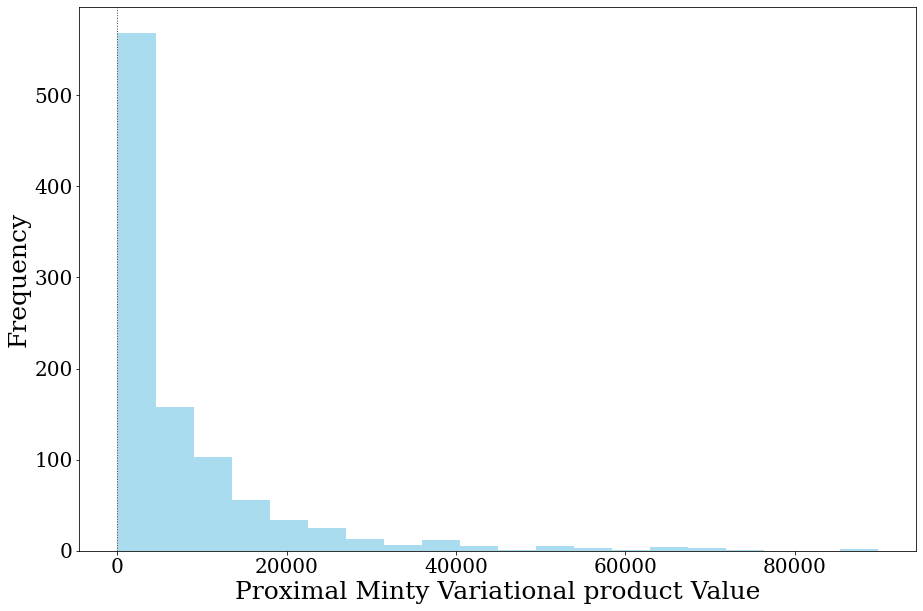

In [52]:
font = {'family': 'serif', 'weight': 'normal', 'size': 25}
font1 = {'family': 'serif', 'size': 20}

plt.figure(figsize=(15, 10))

plt.hist(pmvi_values, bins=20, alpha=0.7, color='skyblue')
plt.axvline(0, color='green', linestyle='dotted', linewidth=1)
plt.xlabel("Proximal Minty Variational product Value",fontdict=font)
plt.ylabel("Frequency",fontdict=font)
# plt.title("Distribution of PMVI Values Around Optimal Solution",fontdict=font)
plt.xticks(fontname='serif', fontsize=20, color='black')
plt.yticks(fontname='serif', fontsize=20, color='black')
# plt.legend()
plt.savefig('Pics/pmvi.pdf', format='pdf',bbox_inches='tight')


In [50]:
negative_count = np.sum(np.array(pmvi_values) <= 0)
print(f"Number of negative elements: {negative_count}")
# print(total_loss(u2_p,u1_p))

Number of negative elements: 0


In [ ]:
pmvi_values2,u1c2,u2c2 = check_prox_minty_vi_batch(u2c, u1c, num_samples=500)

In [ ]:
negative_count2 = np.sum(np.array(pmvi_values2) <= 0)
print(f"Number of negative elements: {negative_count2}")

In [ ]:
state_car1 = simulate_car(car1, initial_states[0],t, u1_p)
state_car2 = simulate_car(car2, initial_states[1],t, u2_p)


# Combine the states for animation (concatenate along axis 1)
states_combined = jnp.hstack([state_car1, state_car2])

# Animation (similar as before)
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(-10, 200)
ax.set_ylim(-20, 20)
ax.set_aspect('equal')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_title('Optimized Lane Merge')
plt.grid('on')

car_colors = ['r', 'b']
car_patches = [Rectangle((0, 0), L, W, fc=color, ec='k') for color in car_colors]
for patch in car_patches:
    ax.add_patch(patch)

car_trails = [ax.plot([], [], '--', color=color)[0] for color in car_colors]

def init():
    for patch in car_patches:
        patch.set_xy((-2, -1))
    for trail in car_trails:
        trail.set_data([], [])
    return car_patches + car_trails

def animate(i):
    for j, patch in enumerate(car_patches):
        x, y, theta, _ = states_combined[i, j*4:(j+1)*4]
        patch.set_xy((x - 2, y - 1))
        patch.set_angle(np.degrees(theta))
        
        trail = car_trails[j]
        trail_data = trail.get_data()
        trail_x = np.append(trail_data[0], x)
        trail_y = np.append(trail_data[1], y)
        trail.set_data(trail_x, trail_y)
    
    return car_patches + car_trails

anim = FuncAnimation(fig, animate, init_func=init, frames=len(t), interval=150, blit=True)

plt.close(fig)
HTML(anim.to_jshtml())